MAD Statistics

In [104]:
import os 
from scipy.io import loadmat
import Actigraph_Metrics
import numpy as np
from scipy import stats
import math
import itertools 
import neurokit2 as nk
from tsfel import auc, calc_std
import pandas as pd

#Place MAD data into SBS groups
data_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\DT 6\NewPedAccel\VentilatedPatientData"
window_size = 100 # 100 is 1 second worth of time

lead_time = 10
slice_size_min = 15

Tag = "Retro"

min = 5

In [105]:
def calc_Exertion(accel_data, hr_data):
    auc_accel =  auc(accel_data, 100)
    hr_std = calc_std(hr_data)
    return 2.1718**(auc_accel + hr_std)


def compute_heart_rate(ecg_signal, sampling_rate):
    """
    Compute heart rate from an ECG signal using the NeuroKit library.

    Parameters:
        ecg_signal (array-like): The ECG signal.
        sampling_rate (int or float): The sampling rate of the ECG signal in Hz.

    Returns:
        dict: A dictionary containing heart rate (in beats per minute) and processed ECG data.
    """
    try:
        # Process the ECG signal
        processed_ecg, info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)

        # Extract the heart rate
        heart_rate = processed_ecg["ECG_Rate"].values

        return {
            "heart_rate": heart_rate,
            "processed_ecg": processed_ecg,
            "info": info
        }
    except Exception as e:
        print(f"An error occurred while computing heart rate: {e}")
        return None
    
    # Replace NaN values with unique timestamps (ensuring no intersection with valid timestamps)
def replace_nans_with_unique_timestamps(time_array, replacement_value):
    # Convert to pandas datetime if the time_array is not already in pandas datetime format
    if not isinstance(time_array, pd.DatetimeIndex):
        time_array = pd.to_datetime(time_array)

    # Replace NaT (Not a Time) with the replacement value
    time_array_with_replacement = time_array.copy()
    time_array_with_replacement[time_array.isna()] = pd.to_datetime(replacement_value, errors='coerce')
    return time_array_with_replacement



In [106]:
import matplotlib.pyplot as plt

def plot_signal_with_prn(signal, time, prn, title):
    """
    Plot a signal versus time and draw vertical lines where the prn list contains "y".
    
    Parameters:
        signal (list or array-like): The signal data.
        time (list or array-like of pandas.Timestamp): The time values corresponding to the signal.
        prn (list): A list with "y" or other markers. Vertical lines are drawn where "y" is present.
    """
    # Plot the signal against time
    plt.plot(time, signal, label="Signal", color='b')
    
    # Draw vertical lines where 'y' is present in prn
    for i, value in enumerate(prn):
        if value == "Y":
            plt.axvline(x=time[i], color='r', linestyle='--', label="PRN Mark" if i == prn.index("Y") else "")
    
    # Label the axes and show the plot
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-ticks for better readability
    plt.show()

**Use SICKBAY Retrospective data to compute metric**

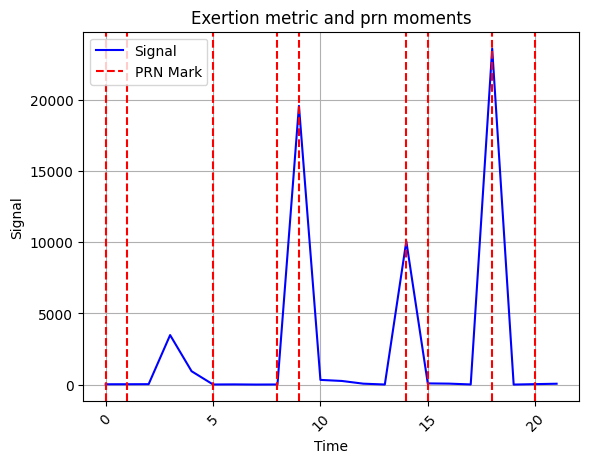

In [107]:
#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):

        #Vitals Data
        vitals_file_path = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_Retro.mat')
        if not os.path.isfile(vitals_file_path):
            continue
        vitals_data = loadmat(vitals_file_path)
        hr = vitals_data["heart_rate"]
        # time = vitals_data['start_time'].flatten()
        sbs = vitals_data['sbs'].flatten()
        x_mag = vitals_data["x_mag"]
        retro_PRN = vitals_data['PRNs'].flatten()
        # Remove all white spaces from each string
        retro_PRN = [s.replace(" ", "") for s in retro_PRN]

        exertion = []
        times = []
        PRNs = [] #Need retrospective ecg data to use PRN info

        for i in range(len(sbs) - 1):
            if(retro_PRN[i] != 'nan'):
                PRNs.append(retro_PRN[i])

                accel_signal = x_mag[i]
                accel_signal = Actigraph_Metrics.VecMag_MAD(accel_signal, window=100)

                hr_signal = hr[i]

                exertion_score = calc_Exertion((accel_signal), hr_signal)
                exertion.append(exertion_score)

                times.append(i) #PROBLEMS WITH SICKBAY DATE TIME OBJECT IN .MAT FILE

    # Ensure the arrays are 1D
    times = np.array(times).squeeze()  # Flatten or remove extra dimensions

    
    # Convert datetime objects to numpy datetime64 and calculate seconds since the epoch
    plot_signal_with_prn(exertion, times, PRNs, title = "Exertion metric and prn moments")





**ECG Data used to compute metric**

In [108]:

#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):


        #Retro data for PRN
        retro_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN_Accel_Retro.mat')
        if not os.path.isfile(retro_accel):
            continue
        accel_retro_data = loadmat(retro_accel)
        retro_prn_times = accel_retro_data ['start_time'].flatten()
        retro_PRN = accel_retro_data['PRN'].flatten()


        #Accel data
        data_filepath_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN_Accel_{Tag}.mat')
        if not os.path.isfile(data_filepath_accel):
            continue

        accel_data = loadmat(data_filepath_accel)
        x_mag = accel_data["x_mag"]
        accel_sbs = accel_data["sbs"].flatten()        
        accel_time = accel_data["start_time"].flatten()
        
        # Load the ECG data
        ecg_file_path = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN_ECG_SBSFinal.mat')
        ecg_data = loadmat(ecg_file_path)
        ecg1 = ecg_data["ecg1"]
        ecg2 = ecg_data["ecg2"]
        ecg3 = ecg_data["ecg3"]
        ecg_sbs = ecg_data['sbs_score'].flatten()
        ecg_time = ecg_data["start_time"].flatten()

        #Line up the data

        #replace nan values with uniqe time stamps that will later be removed
        # accel_time = replace_nans_with_unique_timestamps(accel_time, current_time = pd.Timestamp.now() + pd.Timedelta(minutes=10))
        # ecg_time = replace_nans_with_unique_timestamps(ecg_time, pd.Timestamp.now() + pd.Timedelta(minutes=20))
        # retro_prn_times = replace_nans_with_unique_timestamps(retro_prn_times, pd.Timestamp.now() + pd.Timedelta(minutes=30))
    
        # Find the intersection of the start_time values (timestamps)
        common_times = np.intersect1d(np.intersect1d(accel_time, ecg_time), retro_prn_times)

        # Find the indices for each dataset corresponding to the common times
        accel_indices = np.isin(accel_time, common_times)
        ecg_indices = np.isin(ecg_time, common_times)
        retro_prn_indices = np.isin(retro_prn_times, common_times)

        # Filter the accelerometer data by the common start_time values
        x_mag = x_mag[accel_indices]
        accel_sbs = accel_sbs[accel_indices]
        accel_time = accel_time[accel_indices]
        
        # Filter the ECG data by the common start_time values
        ecg1 = ecg1[ecg_indices]
        ecg2 = ecg2[ecg_indices]
        ecg3 = ecg3[ecg_indices]
        ecg_time = ecg_time[ecg_indices]
        ecg_sbs = ecg_sbs[ecg_indices]

        # Filter the PRN data by the common start_time values
        retro_PRN = retro_PRN[retro_prn_indices]
        retro_prn_time = retro_prn_times[retro_prn_indices]


        exertion1 = []
        exertion2 = []
        exertion3 = []
        times = []
        PRNs = [] #Need retrospective ecg data to use PRN info

        for i in range(len(accel_sbs) - 1):
            if(retro_prn_times[i] == accel_time[i] and accel_time[i] == ecg_time[i]): #check there is a time when all ecg nurse and retro accel line up
                print("Calculating metric")
                PRNs.append(retro_PRN)

                accel_signal = x_mag[i]
                MAD_accel = Actigraph_Metrics.VecMag_MAD(accel_signal, window=100)

                ecg1_signal = ecg1[i]
                ecg2_signal = ecg2[i]
                ecg3_signal = ecg3[i]

                HR_dict1 = compute_heart_rate(ecg1_signal, 250)
                HR1 = HR_dict1["heart_rate"]

                HR_dict2 = compute_heart_rate(ecg2_signal, 250)
                HR2 = HR_dict2["heart_rate"]            
                
                HR_dict3 = compute_heart_rate(ecg3_signal, 250)
                HR3 = HR_dict3["heart_rate"]

                exertion_score_1 = calc_Exertion(MAD_accel, HR1)
                exertion1.append(exertion_score_1)

                exertion_score_2 = calc_Exertion(MAD_accel, HR2)
                exertion2.append(exertion_score_2)

                exertion_score_3 = calc_Exertion(MAD_accel, HR3)
                exertion3.append(exertion_score_3)

                times.append(accel_time[i])

    plot_signal_with_prn(exertion1, times, PRNs, title = "ecg1 exertion metric with prn markers")
    plot_signal_with_prn(exertion2, times, PRNs, title = "ecg2 exertion metric with prn markers")
    plot_signal_with_prn(exertion3, times, PRNs, title = "ecg3 exertion metric with prn markers")

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'